In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/Johnson/LLCP2023.csv')
df.head(3)

_STATE  FMONTH    IDATE  IMONTH  IDAY  IYEAR  DISPCODE       SEQNO  \
0     1.0     1.0  3012023       3     1   2023    1100.0  2023000001   
1     1.0     1.0  1062023       1     6   2023    1100.0  2023000002   
2     1.0     1.0  3082023       3     8   2023    1100.0  2023000003   

           _PSU  CTELENM1  ...      DROCDY4_  _RFBING6      _DRNKWK2  \
0  2.023000e+09       1.0  ...  5.397605e-79       1.0  5.397605e-79   
1  2.023000e+09       1.0  ...  5.397605e-79       1.0  5.397605e-79   
2  2.023000e+09       1.0  ...  5.397605e-79       1.0  5.397605e-79   

   _RFDRHV8  _FLSHOT7  _PNEUMO3  _AIDTST4  _RFSEAT2  _RFSEAT3  _DRNKDRV  
0       1.0       2.0       2.0       2.0       1.0       1.0       9.0  
1       1.0       1.0       1.0       2.0       1.0       1.0       9.0  
2       1.0       1.0       1.0       2.0       1.0       1.0       9.0  

[3 rows x 350 columns]

# Feature Selections

In [2]:
import numpy as np
df_filter = df.copy()
missing_9_columns = ['_RFHLTH', '_PHYS14D', '_MENT14D', '_HLTHPL1', '_TOTINDA', '_PACAT3', '_PA150R4', '_PA300R4', '_PA30023', '_PASTRNG', '_PAREC3', '_PASTAE3', '_RFHYPE6', '_CHOLCH3', '_RFCHOL3', '_LTASTH1', '_CASTHM1', '_ASTHMS1', '_RFBMI5', '_RACE', '_SMOKER3', '_RFSMOK3', '_CURECI2', '_RFBING6','_PAINDX3','_EDUCAG','_INCOMG1','_RFSEAT2']
missing_99900_columns = ['MAXVO21_', 'FC601_', '_DRNKWK2']
missing_900_columns = ['DROCDY4_']

df_filter.loc[:, missing_9_columns] = df_filter.loc[:, missing_9_columns].replace(9, np.nan)
df_filter.loc[:, missing_99900_columns] = df_filter.loc[:, missing_99900_columns].replace(99900, np.nan)
df_filter.loc[:, missing_900_columns] = df_filter.loc[:, missing_900_columns].replace(900, np.nan)

df_filter = df_filter[df_filter['_MICHD'].notna()] #drop rows where heart disease state is missing

for column in df_filter.columns:
    if df_filter[column].isnull().any():  # Check if there are null values
        most_frequent_value = df_filter[column].mode()  # Get the most frequent value
        if len(df_filter[column].mode())>0:
          df_filter[column] = df_filter[column].fillna(most_frequent_value[0])
        else:
          df_filter.drop(column, axis=1, inplace=True)

<ipython-input-2-5986eb9e19d3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter[column] = df_filter[column].fillna(most_frequent_value[0])


In [7]:
# def RemoveHighlyCorrelatedFeatures(df, correlation_matrix, threshold):
#     upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
#     to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
#     print('dropping columns:', to_drop)
#     return to_drop

# df_filter = df_filter.drop(columns=RemoveHighlyCorrelatedFeatures(df_filter,correlation_matrix, 0.81))

dropping columns: ['IMONTH', '_PSU', 'ACETTHEM', '_STSTR', '_WT2RAKE', '_PHYS14D', '_MENT14D', 'FC601_', 'PADUR2_', 'PAMIN13_', 'PAMIN23_', 'PA3VIGM_', '_PACAT3', '_PAINDX3', '_PA150R4', '_PA300R4', '_PAREC3', '_RFHYPE6', '_ASTHMS1', '_RACE', '_RACEGR3', '_RACEPRV', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'HTM4', '_BMI5', '_BMI5CAT', '_RFBMI5', '_EDUCAG', '_SMOKER3', '_RFSMOK3', '_RFBING6', '_RFDRHV8', '_PNEUMO3', '_AIDTST4', '_DRNKDRV']


In [4]:
df_filter = df_filter.drop(columns =['IMONTH', '_PSU', 'ACETTHEM', '_STSTR', '_WT2RAKE', '_PHYS14D', '_MENT14D', 'FC601_', 'PADUR2_', 'PAMIN13_', 'PAMIN23_', 'PA3VIGM_', '_PACAT3', '_PAINDX3', '_PA150R4', '_PA300R4', '_PAREC3', '_RFHYPE6', '_ASTHMS1', '_RACE', '_RACEGR3', '_RACEPRV', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'HTM4', '_BMI5', '_BMI5CAT', '_RFBMI5', '_EDUCAG', '_SMOKER3', '_RFSMOK3', '_RFBING6', '_RFDRHV8', '_PNEUMO3', '_AIDTST4', '_DRNKDRV'])
df_filter = df_filter.drop(columns = ['CVDINFR4', 'CVDCRHD4'])

In [5]:
df_filter.loc[df_filter['_MICHD'] == 2, '_MICHD'] = 0
df_filter['_MICHD'].value_counts() # 0: no CHD, 1: has CHD

_MICHD
0.0    392427
1.0     36311
Name: count, dtype: int64

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = df_filter.drop('_MICHD', axis=1)
y = df_filter['_MICHD']
print(X.shape, y.shape)

(428738, 303) (428738,)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRFClassifier
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
import numpy as np

lasso = Lasso(alpha=0.005)
lasso.fit(X_train, y_train)

# Get selected features
X_columns = df_filter.drop('_MICHD', axis=1).columns
selected_features = X_columns[lasso.coef_ != 0]
print("Selected Features:", selected_features)

# Feature importance (non-zero coefficients)
feature_importances = lasso.coef_[lasso.coef_ != 0]
print("Feature Importances:", feature_importances)

Selected Features: Index(['SEXVAR', 'GENHLTH', 'BPHIGH6', 'CHOLMED3', 'CVDSTRK3', 'CHCCOPD3',
       'CHCKDNY2', 'DIABETE4', 'EMPLOY1', 'DIFFWALK', 'FALL12MN', 'FALLINJ5',
       'SMOKE100', 'ASPIRIN', '_RFHLTH', '_HCVU653', 'MAXVO21_', '_RFCHOL3',
       '_DRDXAR2'],
      dtype='object')
Feature Importances: [-0.01686201  0.01979207 -0.01246602 -0.01291269 -0.00884276 -0.00306115
 -0.00028444 -0.00818525  0.00903221 -0.00422746 -0.0008314  -0.00184901
 -0.00014412 -0.00486585  0.01893199  0.00509571 -0.02753211  0.00689794
 -0.00378418]


## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRFClassifier
from imblearn.over_sampling import SMOTE

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, C=0.001, penalty='l2',solver='saga',class_weight='balanced')
X = df_filter[selected_features]
y = df_filter['_MICHD']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train.shape, y_train.shape)

# Train logistic regression on the reduced dataset
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
f1_logreg = f1_score(y_test, y_pred_logreg)
print(f"Logistic Regression F1 Score: {f1_logreg}")

After SMOTE: (627882, 28) (627882,)
Logistic Regression F1 Score: 0.3498997508961662


## AdaBoostClassifier

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRFClassifier
from imblearn.over_sampling import SMOTE

# Initialize and train the Logistic Regression model
ada_model = AdaBoostClassifier(random_state=42)
X = df_filter[selected_features]
y = df_filter['_MICHD']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train.shape, y_train.shape)

# Train logistic regression on the reduced dataset
ada_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = ada_model.predict(X_test)

# Evaluate the model
f1_ada = f1_score(y_test, y_pred_logreg)
print(f"AdaBoostClassifier F1 Score: {f1_ada}")

After SMOTE: (627882, 28) (627882,)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier F1 Score: 0.3955187530443254


# Plot

## (1) Feature correlations

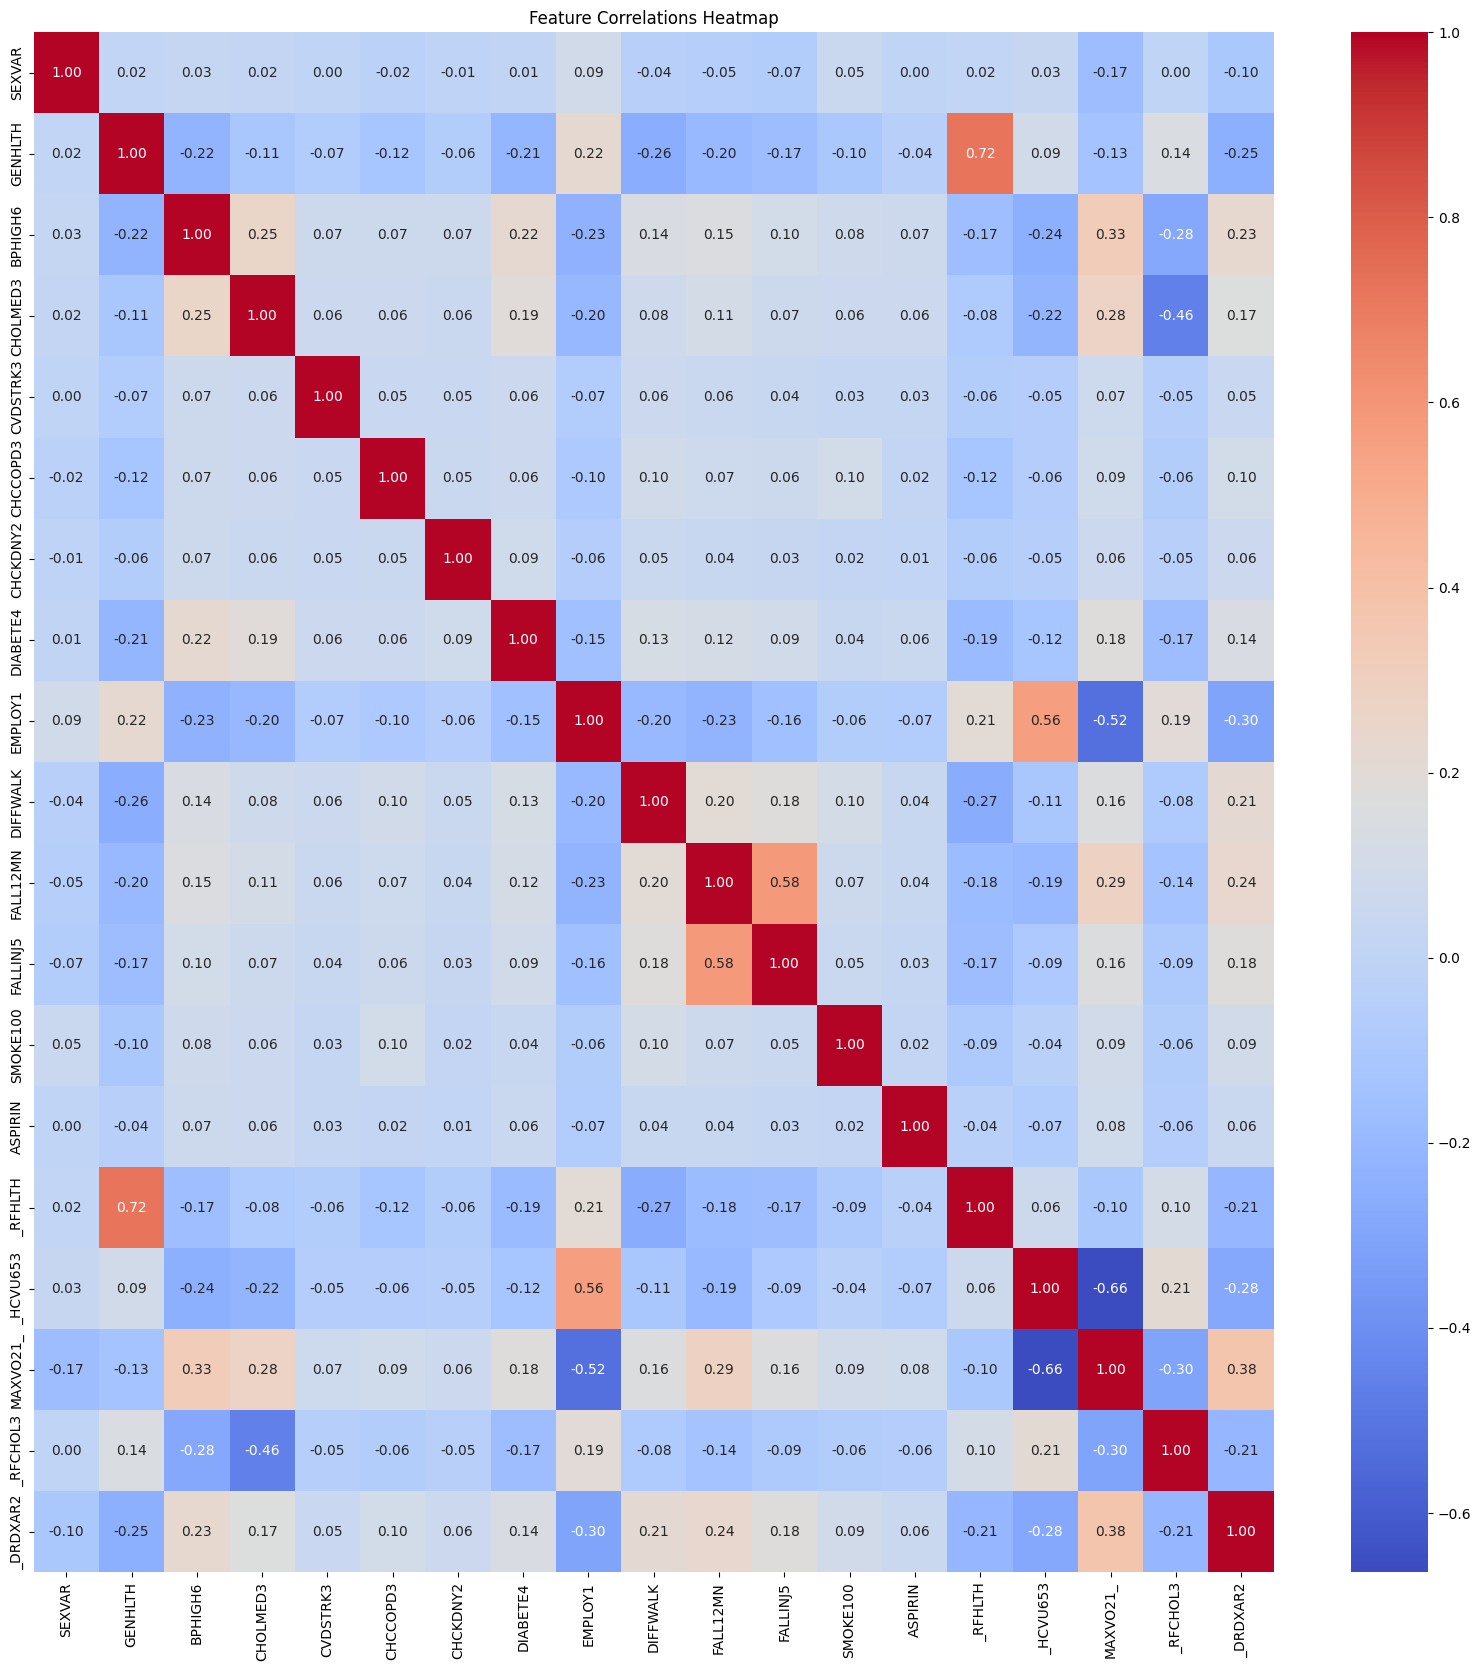

In [13]:
# (1) Feature correlations
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df_filter[selected_features].corr()

plt.figure(figsize=(20, 20))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlations Heatmap")
plt.show()

## (2) Best model feature weights

### Logistic Regression Model

<ipython-input-22-74cc75d81823>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=feature_weights, palette='coolwarm')


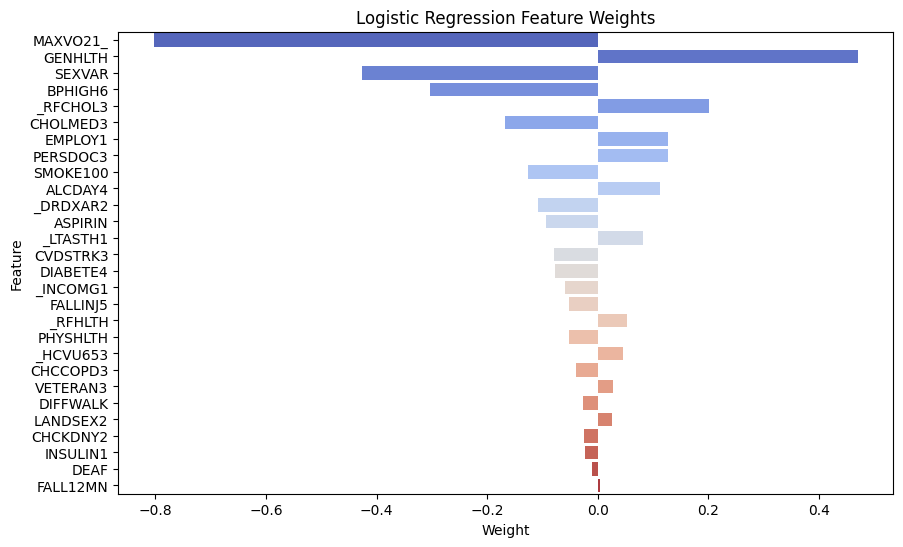

In [22]:
# (2) Best model feature weights
import matplotlib.pyplot as plt
import seaborn as sns
weights = logreg_model.coef_[0]  # Binary classification
feature_weights = pd.DataFrame({
    'Feature': df_filter[selected_features].columns,
    'Weight': weights
})

# Sort by absolute weight
feature_weights = feature_weights.sort_values(by="Weight", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=feature_weights, palette='coolwarm')
plt.title("Logistic Regression Feature Weights")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.show()

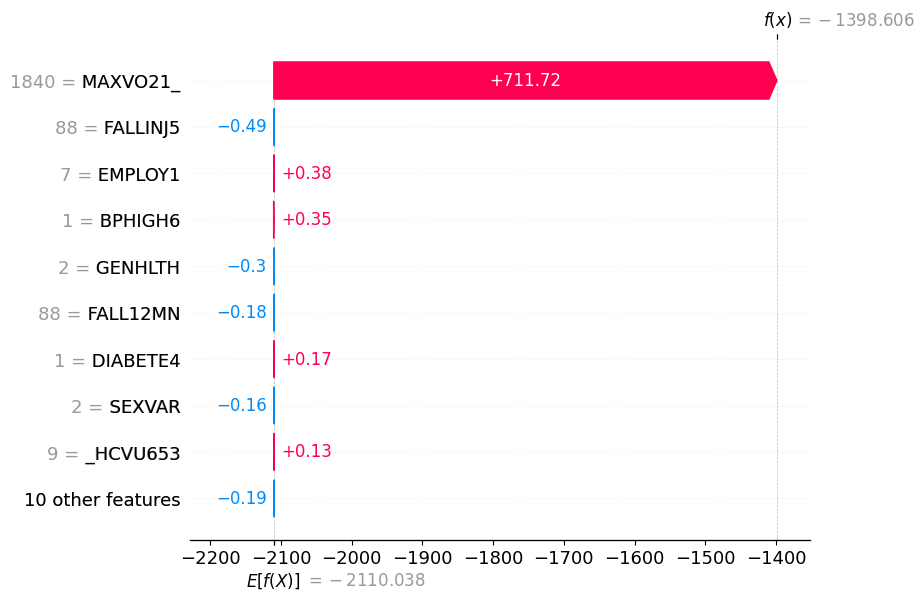

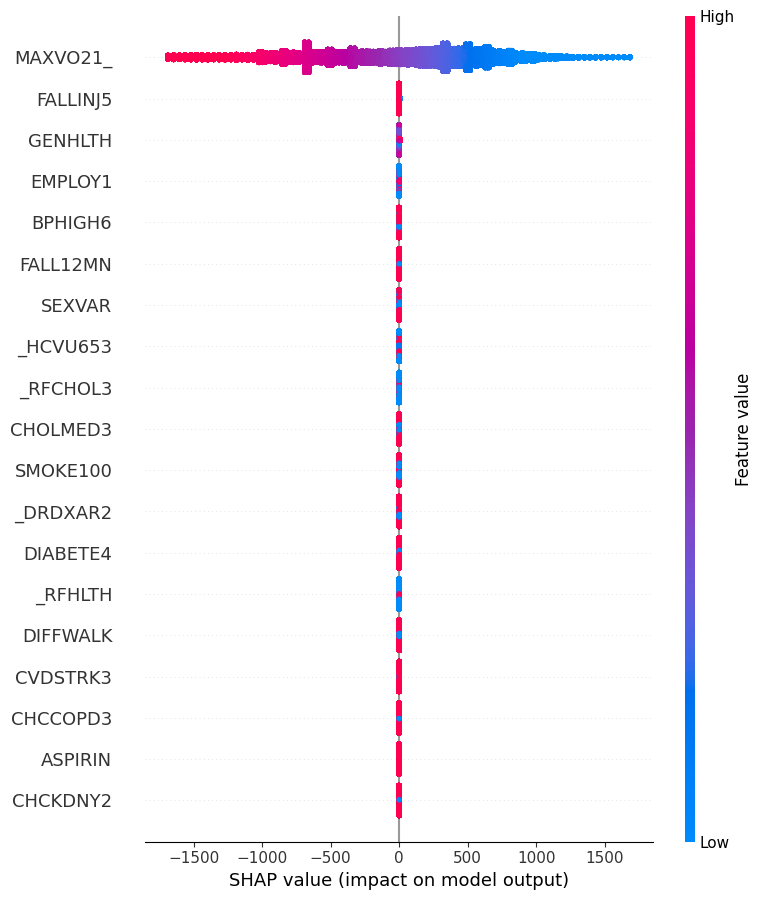

In [15]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(logreg_model, df_filter[selected_features])

# Calculate SHAP values
shap_values = explainer(df_filter[selected_features])

# Visualize SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])
# Summary plot to show global importance
shap.summary_plot(shap_values, df_filter[selected_features])


In [16]:
from lime import lime_tabular

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=df_filter[selected_features].columns,
    class_names=['No CHD', 'With CHD'],
    mode='classification'
)

# Explain a single prediction
instance = X_train[0]  # The instance to explain
exp = explainer.explain_instance(instance, logreg_model.predict_proba)

# Visualize the explanation
exp.show_in_notebook(show_table=True)


### AdaBoostClassifier

<ipython-input-18-660e8a841ae9>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_weights, palette='coolwarm')


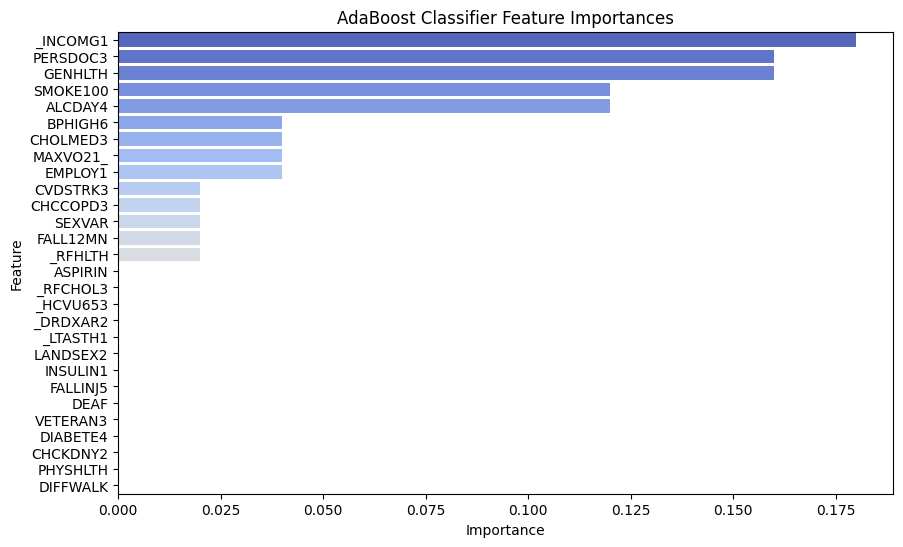

In [18]:
feature_importances = ada_model.feature_importances_

# Create a DataFrame to store features and their importances
feature_weights = pd.DataFrame({
    'Feature': df_filter[selected_features].columns,  # Adjust based on your feature selection
    'Importance': feature_importances
})

# Sort by absolute importance
feature_weights = feature_weights.sort_values(by="Importance", ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_weights, palette='coolwarm')
plt.title("AdaBoost Classifier Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [27]:
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=df_filter[selected_features].values,
    feature_names=df_filter[selected_features].columns,
    class_names=["No CHD", "With CHD"],  # Replace with your class labels
    mode="classification",  # For classification tasks
)

# Choose a data point to explain (e.g., the first row)
data_point = df_filter[selected_features].iloc[0].values

# Explain the prediction for the chosen data point
explanation = explainer.explain_instance(data_point, ada_model.predict_proba)

# Visualize the explanation
explanation.show_in_notebook()


## (3) Different feature combinations vs. F1 score

alpha 0.001 Selected Features: Index(['DISPCODE', 'PVTRESD1', 'LANDSEX2', 'LNDSXBRT', 'SEXVAR', 'GENHLTH',
       'PHYSHLTH', 'POORHLTH', 'PRIMINS1', 'PERSDOC3', 'CHECKUP1', 'EXERANY2',
       'STRENGTH', 'BPHIGH6', 'BPMEDS1', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3',
       'CVDSTRK3', 'CHCSCNC1', 'CHCCOPD3', 'CHCKDNY2', 'DIABETE4', 'DIABAGE4',
       'EDUCA', 'RENTHOM1', 'CPDEMO1C', 'VETERAN3', 'EMPLOY1', 'DEAF', 'BLIND',
       'DECIDE', 'DIFFWALK', 'FALL12MN', 'FALLINJ5', 'SMOKE100', 'USENOW3',
       'ECIGNOW2', 'ALCDAY4', 'FLSHTMY3', 'HIVTST7', 'HIVTSTD3', 'SEATBELT',
       'COVIDACT', 'INSULIN1', 'FEETSORE', 'LCSCTSC1', 'HOWLONG', 'CERVSCRN',
       'CRVCLCNC', 'CRVCLHPV', 'PSATIME1', 'COLNTES1', 'CNCRDIFF', 'CNCRAGE',
       'CNCRTYP2', 'CSRVTRT3', 'CDWORRY', 'CDDISCU1', 'CDHOUS1', 'STOPSMK2',
       'GUNLOAD', 'HASYMP1', 'HASYMP2', 'HASYMP4', 'STRSYMP2', 'FIRSTAID',
       'ASPIRIN', 'USEMRJN4', 'COVIDNU2', 'LSATISFY', 'EMTSUPRT', 'SDHFOOD1',
       'RRCOGNT2', 'RRPHYSM2', 'QSTLANG'

<ipython-input-36-6398ebeedd48>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Feature Combination', data=results_df, palette='viridis')


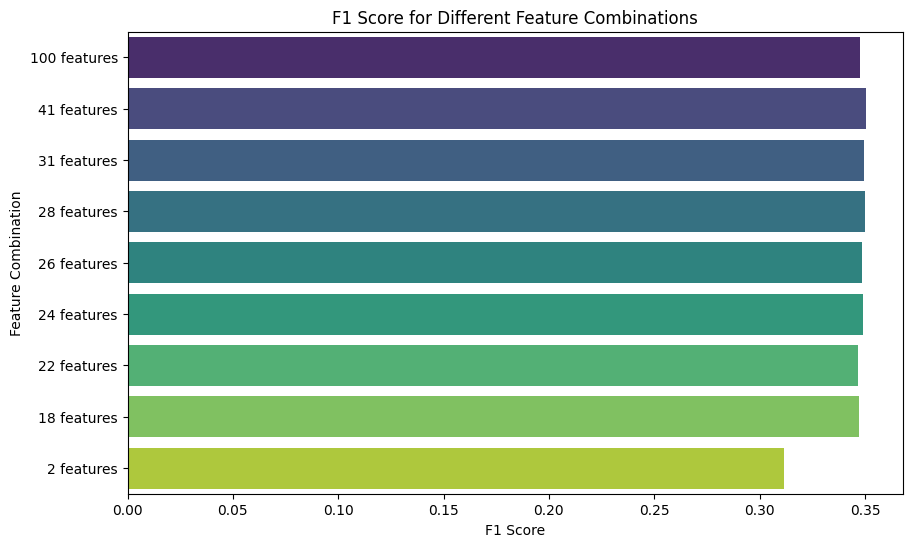

In [36]:
# (3) Different feature combinations vs. F1 score
# alphas 18 features, 0.1 - 0 feature, 0.0001 - 262 features, 0.0005 - 165 features, 0.0007 - 135 features, 0.0009 - 110 features, 0.001-100 features
alphas = [0.001, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01, 0.05]
results = []
for alpha in alphas:

    # Split data
    X = df_filter.drop('_MICHD', axis=1)
    y = df_filter['_MICHD']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    X_columns = df_filter.drop('_MICHD', axis=1).columns
    selected_features = X_columns[lasso.coef_ != 0]
    print("alpha", alpha, "Selected Features:", selected_features)

    logreg_model = LogisticRegression(max_iter=1000, C=0.001, penalty='l2',solver='saga',class_weight='balanced')

    X_train, X_test, y_train, y_test = train_test_split(df_filter[selected_features], df_filter['_MICHD'], test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("After SMOTE:", X_train.shape, y_train.shape)

    # Train logistic regression on the reduced dataset
    logreg_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_logreg = logreg_model.predict(X_test)

    # Evaluate the model
    f1_logreg = f1_score(y_test, y_pred_logreg)
    print("F1 score", f1_logreg)
    name = str(len(selected_features))+" features"
    # Store results
    results.append({'Feature Combination': name, 'F1 Score': f1_logreg})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='F1 Score', y='Feature Combination', data=results_df, palette='viridis')
plt.title('F1 Score for Different Feature Combinations')
plt.xlabel('F1 Score')
plt.ylabel('Feature Combination')
plt.show()

## (4) Different models vs. F1 score

Selected Features: Index(['LANDSEX2', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'PERSDOC3', 'BPHIGH6',
       'CHOLMED3', 'CVDSTRK3', 'CHCCOPD3', 'CHCKDNY2', 'DIABETE4', 'VETERAN3',
       'EMPLOY1', 'DEAF', 'DIFFWALK', 'FALL12MN', 'FALLINJ5', 'SMOKE100',
       'ALCDAY4', 'INSULIN1', 'ASPIRIN', '_RFHLTH', '_HCVU653', 'MAXVO21_',
       '_RFCHOL3', '_LTASTH1', '_DRDXAR2', '_INCOMG1'],
      dtype='object')
After SMOTE: (627882, 28) (627882,)
model BernoulliNB() 0.3520517003388129
model GradientBoostingClassifier(random_state=42) 0.38963590593725056


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


model AdaBoostClassifier(random_state=42) 0.3955187530443254
model RidgeClassifier() 0.3428789390293997
model Perceptron(random_state=42) 0.29080659869020975
model LinearDiscriminantAnalysis() 0.3428789390293997
model QuadraticDiscriminantAnalysis() 0.3492855331022237
model MLPClassifier(max_iter=500, random_state=42) 0.3448314231667965


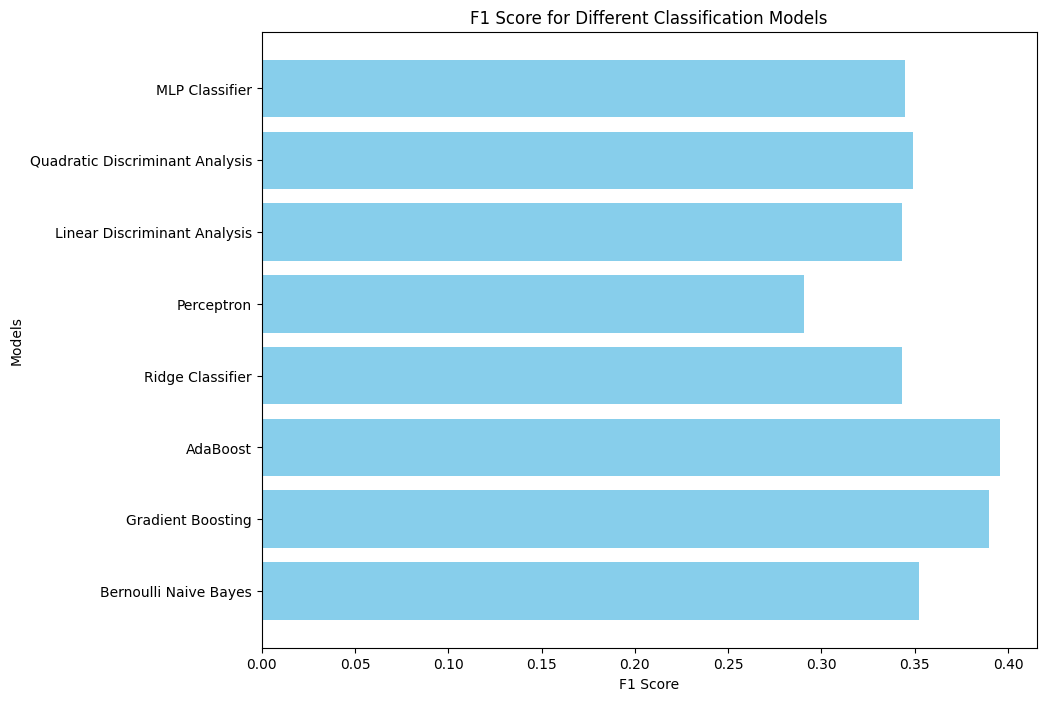

In [7]:
# # (4) Different models vs. F1 score
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression, LassoCV, RidgeClassifier, Perceptron
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Lasso
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE

# X = df_filter.drop('_MICHD', axis=1)
# y = df_filter['_MICHD']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# lasso = Lasso(alpha=0.005)
# lasso.fit(X_train, y_train)
# X_columns = df_filter.drop('_MICHD', axis=1).columns
# selected_features = X_columns[lasso.coef_ != 0]
# print("Selected Features:", selected_features)

# X_train, X_test, y_train, y_test = train_test_split(df_filter[selected_features], df_filter['_MICHD'], test_size=0.2, random_state=42, stratify=y)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)
# print("After SMOTE:", X_train.shape, y_train.shape)

# # Define the models
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000), #0.34960362056920696
#     'Random Forest': RandomForestClassifier(n_estimators=100),#0.23774437567541015
#     'Decision Tree': DecisionTreeClassifier(random_state=42),#0.2643866733972741
#     'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),#0.32593390528219135
#     'Gaussian Naive Bayes': GaussianNB(),#0.3511755138252255
#     'Bernoulli Naive Bayes': BernoulliNB(),#0.3520517003388129
#     'Gradient Boosting': GradientBoostingClassifier(random_state=42),#0.38963590593725056
#     'AdaBoost': AdaBoostClassifier(random_state=42),#0.3955187530443254
#     'Ridge Classifier': RidgeClassifier(),#0.3428789390293997
#     'Perceptron': Perceptron(random_state=42),#0.29080659869020975
#     'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),#0.3428789390293997
#     'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),#0.3492855331022237
#     'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)#0.3448314231667965
# }

# # List to store F1 scores
# f1_scores = []

# # Train models and calculate F1 score
# for model_name, model in models.items():
#     model.fit(X_train, y_train)  # Train the model
#     y_pred = model.predict(X_test)  # Make predictions
#     f1 = f1_score(y_test, y_pred)  # Calculate F1 score
#     print("model", model, f1)
#     f1_scores.append(f1)

# # Plotting
# plt.figure(figsize=(10, 8))
# plt.barh(list(models.keys()), f1_scores, color='skyblue')
# plt.xlabel('F1 Score')
# plt.ylabel('Models')
# plt.title('F1 Score for Different Classification Models')
# plt.show()


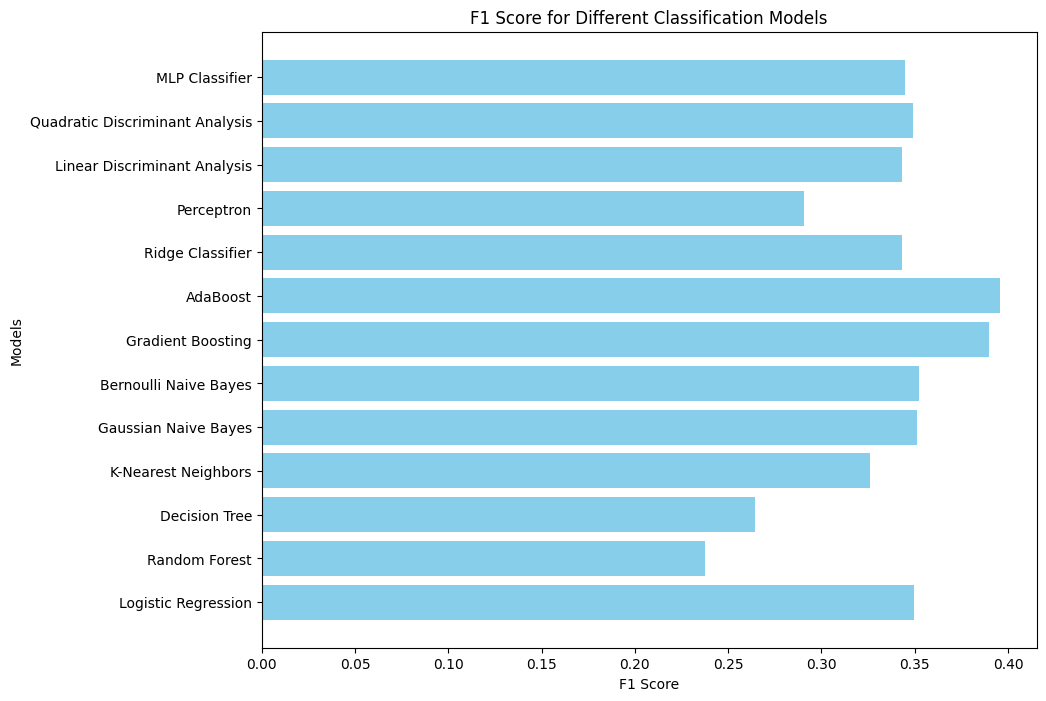

In [8]:
# (4) Different models vs. F1 score
models = {
    'Logistic Regression': 0.34960362056920696,
    'Random Forest': 0.23774437567541015,
    'Decision Tree': 0.2643866733972741,
    'K-Nearest Neighbors': 0.32593390528219135,
    'Gaussian Naive Bayes': 0.3511755138252255,
    'Bernoulli Naive Bayes': 0.3520517003388129,
    'Gradient Boosting': 0.38963590593725056,
    'AdaBoost': 0.3955187530443254,
    'Ridge Classifier': 0.3428789390293997,
    'Perceptron': 0.29080659869020975,
    'Linear Discriminant Analysis': 0.3428789390293997,
    'Quadratic Discriminant Analysis': 0.3492855331022237,
    'MLP Classifier': 0.3448314231667965
}
plt.figure(figsize=(10, 8))
plt.barh(list(models.keys()), list(models.values()), color='skyblue')
plt.xlabel('F1 Score')
plt.ylabel('Models')
plt.title('F1 Score for Different Classification Models')
plt.show()
